# Neural Network Model

## Table of Contents

- [Data Takeover](#Data-Takeover)
    - [Train/Test Split](#Train/Test-Split)
- [Neural Network Implementation](#Neural-Network-Implementation)
    - [Performance Measurement](#Performance-Measurement)

## Data Takeover

Read in DataFrame from chapter [Feature Matrix Generation](./3_FeatureMatrixGeneration.ipynb) as input for processing in this chapter.

In [1]:
import os
import pandas as pd

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

df_labelled_feature_matrix.head()

,duplicates,century_delta,corporate_110_delta,corporate_710_delta,edition_delta,format_prefix_delta,format_postfix_delta,person_245c_delta,ttlfull_245_delta,ttlfull_246_delta,volumes_delta
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.818905,0.363636,1.0,1.0
2,1,1.0,1.0,1.0,1.0,1.0,1.0,0.697740,1.000000,1.0,1.0
3,1,1.0,1.0,1.0,1.0,1.0,1.0,0.818905,0.363636,1.0,1.0
4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0


In [2]:
df_labelled_feature_matrix = pd.concat(
    [df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==0].sample(
        n=len(df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==0])//90
    ),
     df_labelled_feature_matrix[df_labelled_feature_matrix.duplicates==1]])

In [3]:
print('Part of duplicates (1) on uniques (2) in units of [%]')
print(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100)

Part of duplicates (1) on uniques (2) in units of [%]
0    66.161268
1    33.838732
Name: duplicates, dtype: float64


### Train/Test Split

The train/test split will be implemented here as a general function to be called in the models chapters.

In [4]:
X = df_labelled_feature_matrix.drop(columns=['duplicates']).values
y = df_labelled_feature_matrix.duplicates.values

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [6]:
X_tr.shape

(3482, 10)

## Neural Network Implementation

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

l2_alpha = 0.1
sgd_learnrate = 0.05

# Input layer
hidden = Dense(
    12, # Number of units for hidden layer
    input_shape=(X_tr.shape[1],),
    activation='relu',
    kernel_initializer=VarianceScaling(scale=2.0, seed=0),
    kernel_regularizer=l2(l2_alpha),
    bias_initializer='zeros'
)

# With dropout layer
dropout = Dropout(
    rate=0.25,
    seed=0
)

# Output layer
output = Dense(
    2,
#    activation='sigmoid', # Bring out 0 or 1 values
    activation='softmax', # Bring out 0 or 1 values
    kernel_initializer=VarianceScaling(scale=1, seed=0),
    kernel_regularizer=l2(l2_alpha),
    bias_initializer='zeros'
)

# Create model with sequential API
model = Sequential()
model.add( hidden ) # Hidden layer
model.add( dropout ) # Dropout
model.add( output ) # Output layer

# The optimizer is to be SGD
#sgd = SGD(lr=sgd_learnrate)
model_optimizer = Adam(lr=sgd_learnrate)

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
#    metrics=['categorical_accuracy']
)

# Check Model configuration
model.get_config()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 12,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 2.0,
      'mode': 'fan_in',
      'distribution': 'normal',
      'seed': 1}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 0.10000000149011612}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.25,
    'noise_shape': None,
    'seed': 0}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 2,
    'a

In [8]:
from keras.utils import to_categorical

# Parameters for fitting with batches and epochs
epochs = 100
batch_size = 50
# Stay with the four logits and do not reduce to one categorical integer
y_tr_2 = to_categorical(y_tr)
y_val_2 = to_categorical(y_te)

# Fit the model
history = model.fit(
    x=X_tr, y=y_tr_2,
    batch_size=batch_size, epochs=epochs,
    validation_data=(X_te, y_val_2)
)


Train on 3482 samples, validate on 871 samples
Epoch 1/100
3482/3482 [==============================] - 1s 236us/step - loss: 0.8842 - accuracy: 0.8619 - val_loss: 0.5103 - val_accuracy: 0.9357
Epoch 2/100
3482/3482 [==============================] - 0s 45us/step - loss: 0.5370 - accuracy: 0.8897 - val_loss: 0.5041 - val_accuracy: 0.9782
Epoch 3/100
3482/3482 [==============================] - 0s 47us/step - loss: 0.5385 - accuracy: 0.8978 - val_loss: 0.5055 - val_accuracy: 0.9460
Epoch 4/100
3482/3482 [==============================] - 0s 46us/step - loss: 0.5366 - accuracy: 0.9032 - val_loss: 0.5398 - val_accuracy: 0.9656
Epoch 5/100
3482/3482 [==============================] - 0s 46us/step - loss: 0.5552 - accuracy: 0.8823 - val_loss: 0.5215 - val_accuracy: 0.9150
Epoch 6/100
3482/3482 [==============================] - 0s 48us/step - loss: 0.5393 - accuracy: 0.8926 - val_loss: 0.5052 - val_accuracy: 0.9449
Epoch 7/100
3482/3482 [==============================] - 0s 38us/step - los

3482/3482 [==============================] - 0s 45us/step - loss: 0.5339 - accuracy: 0.8992 - val_loss: 0.5654 - val_accuracy: 0.6613
Epoch 56/100
3482/3482 [==============================] - 0s 43us/step - loss: 0.5363 - accuracy: 0.8935 - val_loss: 0.5138 - val_accuracy: 0.9724
Epoch 57/100
3482/3482 [==============================] - 0s 48us/step - loss: 0.5354 - accuracy: 0.9009 - val_loss: 0.4996 - val_accuracy: 0.9736
Epoch 58/100
3482/3482 [==============================] - 0s 59us/step - loss: 0.5347 - accuracy: 0.8983 - val_loss: 0.4962 - val_accuracy: 0.9747
Epoch 59/100
3482/3482 [==============================] - 0s 45us/step - loss: 0.5383 - accuracy: 0.8983 - val_loss: 0.5073 - val_accuracy: 0.9610
Epoch 60/100
3482/3482 [==============================] - 0s 41us/step - loss: 0.5256 - accuracy: 0.9130 - val_loss: 0.4995 - val_accuracy: 0.9759
Epoch 61/100
3482/3482 [==============================] - 0s 39us/step - loss: 0.5376 - accuracy: 0.8917 - val_loss: 0.5009 - val_a

In [9]:
y_tr_2, y_val_2

(array([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32), array([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32))

In [10]:
#from keras.utils import plot_model

#plot_model(model, show_shapes=True, dpi=72)

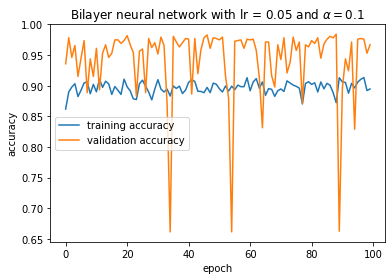

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.title(r'Bilayer neural network with lr = {} and $\alpha=${}'.format(
    sgd_learnrate, l2_alpha)
)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
import numpy as np

no_last = 5 # I take the last 5 due to the upwards shape of the curve at its end
print('Mean last {:d} validation accuracy : {:.3f}'.format(
    no_last, np.mean(history.history['val_accuracy'][-no_last:])
))

print('Neural network accuracy (test set): {:.3f}'.format(
    model.evaluate(X_te, to_categorical(y_te),
                   verbose=0)[1] # Loss is at index=0, accuracy at index=1
))

Mean last 5 validation accuracy : 0.970
Neural network accuracy (test set): 0.967


In [13]:
y_pred = model.predict_classes(X_te)

min(y_pred)

0

### Performance Measurement

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_te, y_pred)

array([[575,   1],
       [ 28, 267]])

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from keras.metrics import accuracy

#print('Score {:.1f}%'.format(100*accuracy_score(X_te, y_te)))
print('Area under the curve {:.1f}% - accuracy {:.1f}% - precision {:.1f}% - recall {:.1f}%'.format(100*roc_auc_score(y_te, y_pred),
                100*accuracy_score(y_te, y_pred),
                100*precision_score(y_te, y_pred),
                100*recall_score(y_te, y_pred)
               ))

Area under the curve 95.2% - accuracy 96.7% - precision 99.6% - recall 90.5%


## Results Handover

In [17]:
import results_saving_funcs as rsf

rsf.add_result_to_results(path_goldstandard, model, X_te, y_te, y_pred)